In [11]:
import numpy as np
import pandas as pd
from iohub import open_ome_zarr
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Load predicted features and projections
predicted_features = np.load("epoch97_predicted_features.npy")
predicted_projections = np.load("epoch97_predicted_projections.npy")

print(predicted_features.shape)
print(predicted_projections.shape)

# Load the CSV file
csv_path = "epoch97_processed_order.csv"
df = pd.read_csv(csv_path)

# Load ground truth masks
base_path = "/hpc/projects/intracellular_dashboard/viral-sensor/2024_02_04_A549_DENV_ZIKV_timelapse/6-patches/all_annotations_patch.zarr"
ds = open_ome_zarr(base_path, layout="hcs", mode="r")

background_mask_index = ds.channel_names.index('background_mask')
uninfected_mask_index = ds.channel_names.index('uninfected_mask')
infected_mask_index = ds.channel_names.index('infected_mask')


(2629, 768, 8, 8)
(2629, 256)


In [12]:
# Assuming all masks have the same shape
# TO-DO:
# tie the image with projected embeddings
# test with ER

# Initialize arrays to store the sums
num_cells = len(df)
background_sums = np.zeros(num_cells)
uninfected_sums = np.zeros(num_cells)
infected_sums = np.zeros(num_cells)

In [13]:
for idx, row in df.iterrows():
    position_key = f"{row['Row']}/{row['Column']}/fov{row['FOV']}cell{row['Cell ID']}/0"
    zarr_array = ds[position_key]
    t = row['Timestep']
    
    # Load a single z-slice, for example the first one
    background_mask = zarr_array[t, background_mask_index, 0, :, :]
    uninfected_mask = zarr_array[t, uninfected_mask_index, 0, :, :]
    infected_mask = zarr_array[t, infected_mask_index, 0, :, :]
    
    # Sum values across each mask
    background_sums[idx] = np.sum(background_mask)
    uninfected_sums[idx] = np.sum(uninfected_mask)
    infected_sums[idx] = np.sum(infected_mask)

In [25]:
# Normalize the sums
max_background = np.max(background_sums)
max_uninfected = np.max(uninfected_sums)
max_infected = np.max(infected_sums)

background_sums /= max_background
uninfected_sums /= max_uninfected
infected_sums /= max_infected

In [26]:
# Combine the sums into a single array and apply softmax
combined_sums = np.stack([background_sums, uninfected_sums, infected_sums], axis=1)
softmax_sums = np.exp(combined_sums) / np.sum(np.exp(combined_sums), axis=1, keepdims=True)

# Separate the softmax values
background_softmax = softmax_sums[:, 0]
uninfected_softmax = softmax_sums[:, 1]
infected_softmax = softmax_sums[:, 2]

In [27]:
# Check for NaN values in the softmax results
print("NaN values in combined_sums:", np.isnan(combined_sums).any())
print("NaN values in softmax_sums:", np.isnan(softmax_sums).any())
print("Infinite values in combined_sums:", np.isinf(combined_sums).any())
print("Infinite values in softmax_sums:", np.isinf(softmax_sums).any())

NaN values in combined_sums: False
NaN values in softmax_sums: False
Infinite values in combined_sums: False
Infinite values in softmax_sums: False


In [28]:
# Check for NaN values in the softmax results
print("NaN values in background_softmax:", np.isnan(background_softmax).any())
print("NaN values in uninfected_softmax:", np.isnan(uninfected_softmax).any())
print("NaN values in infected_softmax:", np.isnan(infected_softmax).any())

# Check for zero variance in the softmax results
print("Variance in background_softmax:", np.var(background_softmax))
print("Variance in uninfected_softmax:", np.var(uninfected_softmax))
print("Variance in infected_softmax:", np.var(infected_softmax))

NaN values in background_softmax: False
NaN values in uninfected_softmax: False
NaN values in infected_softmax: False
Variance in background_softmax: 0.0020539258845222756
Variance in uninfected_softmax: 0.0039155569854069875
Variance in infected_softmax: 0.0026512443426509346


In [29]:
# Determine the number of principal components to keep
#reshaped_features = predicted_features.reshape(predicted_features.shape[0], -1)

pca = PCA()
pca.fit(predicted_projections)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

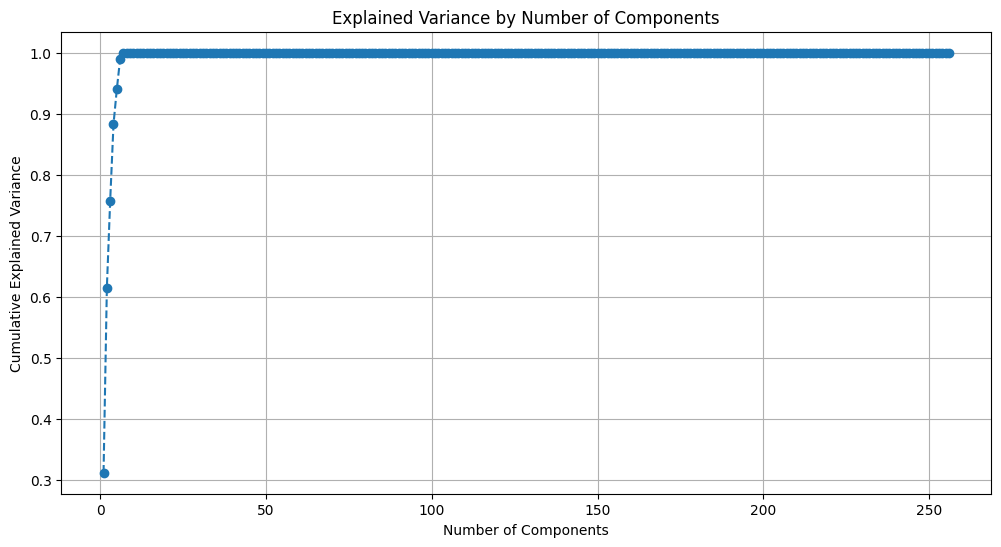

In [30]:
# Plot the explained variance ratio
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [31]:
# Choose the number of components that explain a significant amount of variance (e.g., 90%)
n_components = np.argmax(explained_variance_ratio >= 0.90) + 1
print(f"Number of components selected: {n_components}")

Number of components selected: 5


In [32]:
# Perform PCA with the selected number of components
pca = PCA(n_components=n_components)
reduced_projections = pca.fit_transform(predicted_projections)

In [34]:
# Calculate rank correlations
correlations = []

for i in range(reduced_projections.shape[1]):
    pc = reduced_projections[:, i]
    
    background_corr, _ = spearmanr(pc, background_softmax)
    uninfected_corr, _ = spearmanr(pc, uninfected_softmax)
    infected_corr, _ = spearmanr(pc, infected_softmax)
    
    correlations.append({
        "PC": i + 1,
        "Background Correlation": background_corr,
        "Uninfected Correlation": uninfected_corr,
        "Infected Correlation": infected_corr
    })

correlation_df = pd.DataFrame(correlations)
print(correlation_df)

   PC  Background Correlation  Uninfected Correlation  Infected Correlation
0   1                0.050334               -0.094879              0.079789
1   2               -0.002184                0.016340              0.030856
2   3                0.032372                0.044127             -0.030238
3   4                0.042380               -0.212249              0.181532
4   5                0.011044                0.052858             -0.051418


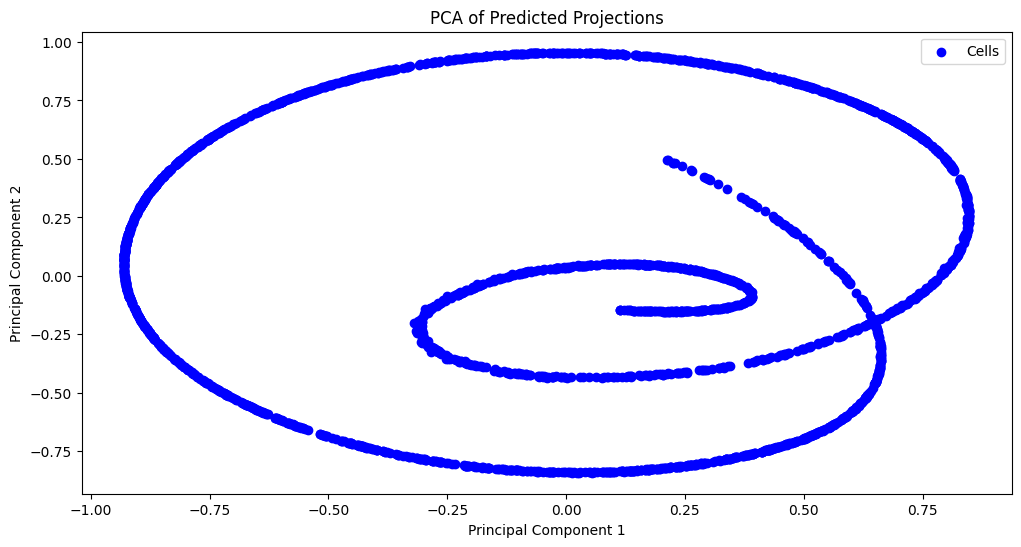

In [35]:
# Visualize the PCA results
plt.figure(figsize=(12, 6))
plt.scatter(reduced_projections[:, 0], reduced_projections[:, 1], c='blue', label='Cells')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Predicted Projections')
plt.legend()
plt.show()


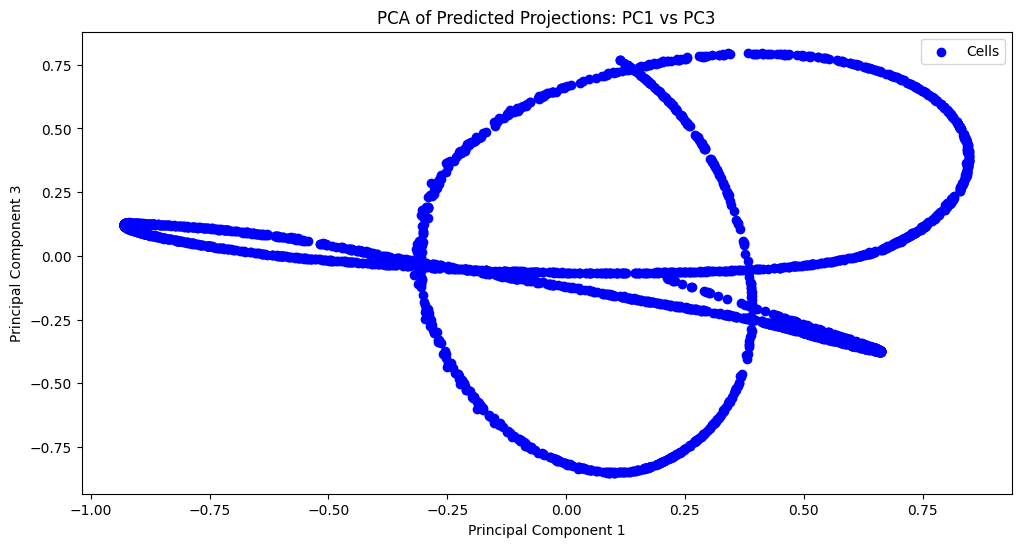

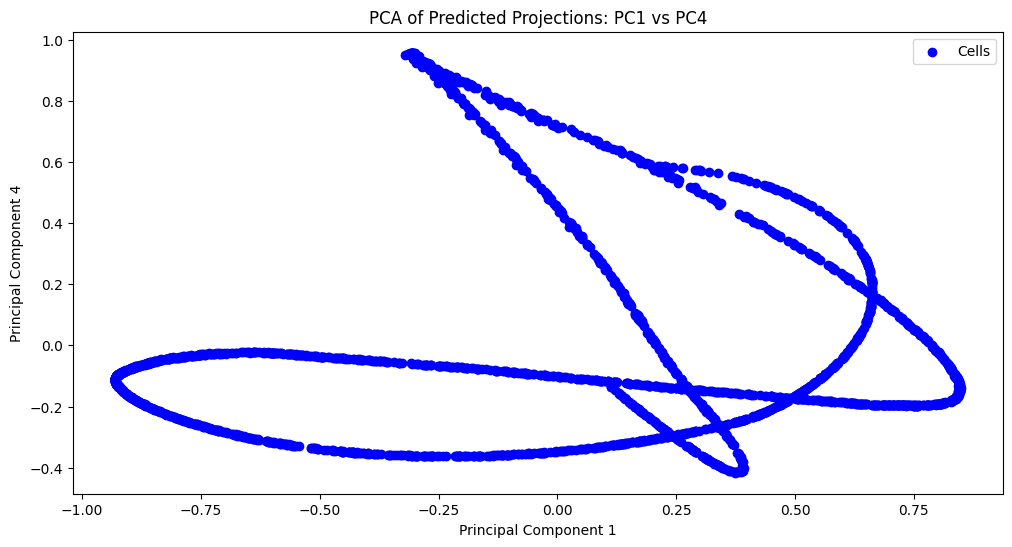

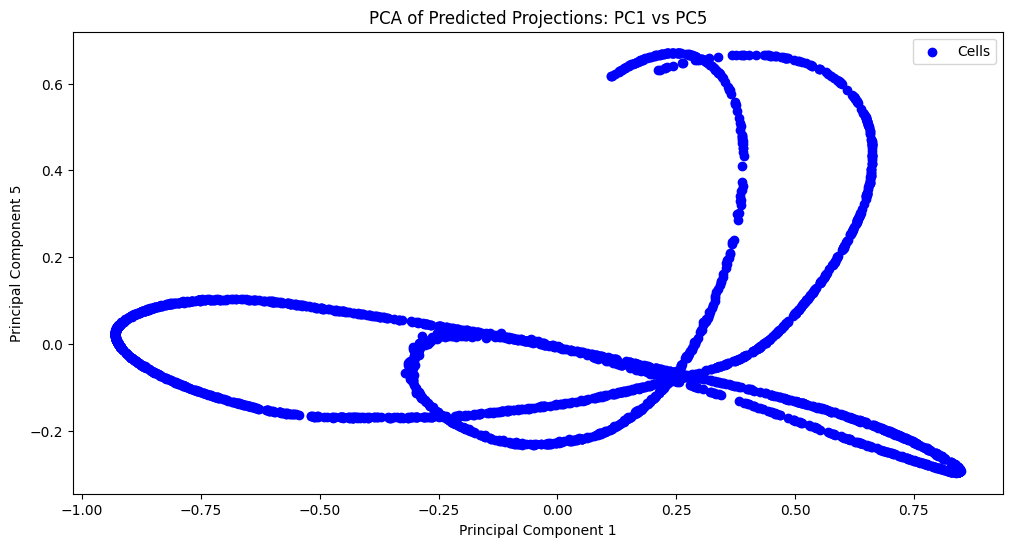

In [36]:
# PC1 vs PC3, PC1 vs PC4, etc.
if n_components > 2:
    for i in range(2, n_components):
        plt.figure(figsize=(12, 6))
        plt.scatter(reduced_projections[:, 0], reduced_projections[:, i], c='blue', label='Cells')
        plt.xlabel('Principal Component 1')
        plt.ylabel(f'Principal Component {i + 1}')
        plt.title(f'PCA of Predicted Projections: PC1 vs PC{i + 1}')
        plt.legend()
        plt.show()

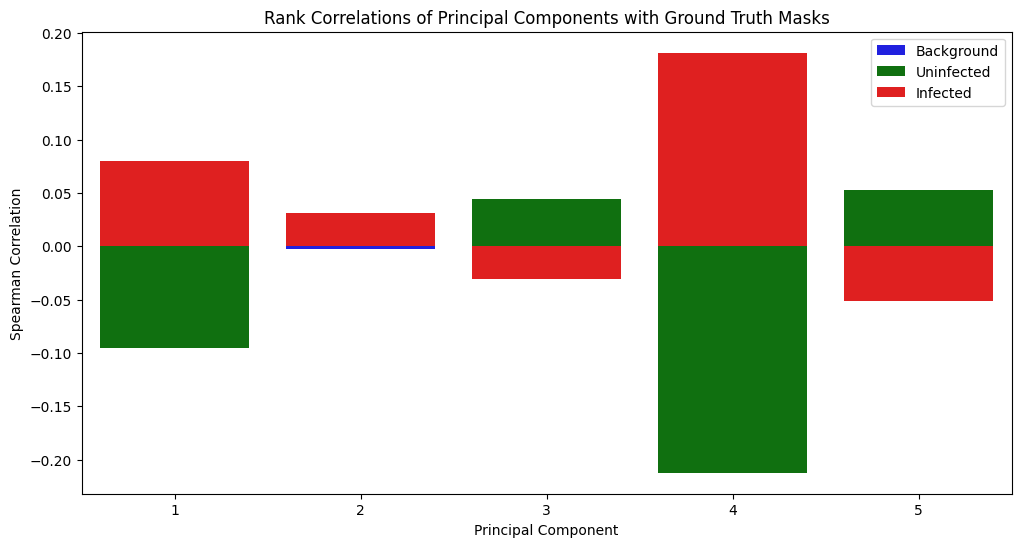

In [37]:
# Visualize the rank correlations
plt.figure(figsize=(12, 6))
sns.barplot(x="PC", y="Background Correlation", data=correlation_df, color='blue', label='Background')
sns.barplot(x="PC", y="Uninfected Correlation", data=correlation_df, color='green', label='Uninfected')
sns.barplot(x="PC", y="Infected Correlation", data=correlation_df, color='red', label='Infected')
plt.xlabel('Principal Component')
plt.ylabel('Spearman Correlation')
plt.title('Rank Correlations of Principal Components with Ground Truth Masks')
plt.legend()
plt.show()

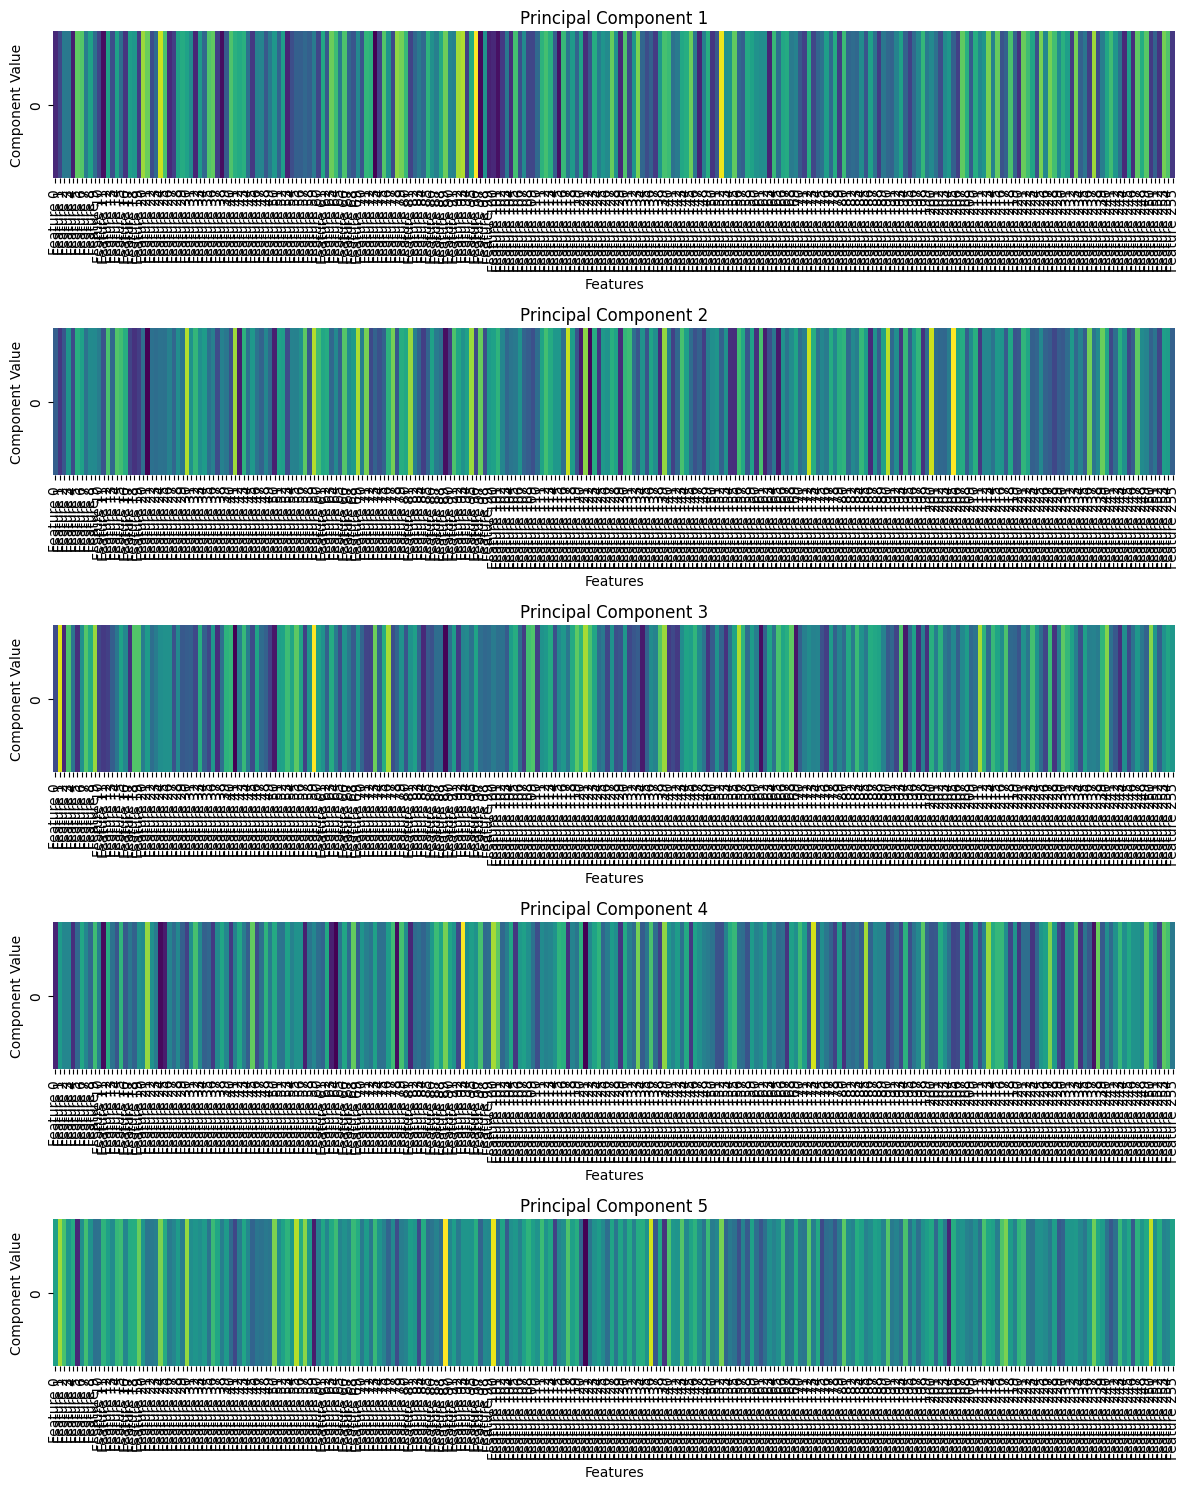

In [38]:
# Visualize the principal components
components = pca.components_

# Assuming your original features are named, you can list them
feature_names = [f"Feature {i}" for i in range(predicted_projections.shape[1])]  # Replace with actual feature names if available

fig, axes = plt.subplots(n_components, 1, figsize=(12, 3 * n_components))
for i, (component, ax) in enumerate(zip(components[:n_components], axes)):
    sns.heatmap(component.reshape(1, -1), cmap='viridis', ax=ax, cbar=False, xticklabels=feature_names)
    ax.set_title(f'Principal Component {i + 1}')
    ax.set_xlabel('Features')
    ax.set_ylabel('Component Value')
plt.tight_layout()
plt.show()